# normal_model

## time pyd_data

In [1]:
# ================== 1️⃣ 导入路径与函数 ==================
%run ../_init_path.py

import os
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import subgraph, add_self_loops

# === 导入模型结构 ===
from models import GraphContrastiveLearner, augment_graph, summarize_graph


# ===================== 0️⃣ 路径设置 =====================
train_graph_path = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/KAIST_CWT/normalization/train/CWT_pyg/train_graph_with_labelmask.pt"
val_graph_path   = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/KAIST_CWT/normalization/val/CWT_pyg/graph.pt"
test_graph_path  = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/KAIST_CWT/normalization/test/CWT_pyg/graph.pt"

save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_CWT/model_save/time_CWT"
os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from torch_geometric.utils import add_self_loops

# ===================== 1️⃣ 加载图数据 =====================
print("\n========== 加载 train 图（带 label mask） ==========")
train_data = torch.load(train_graph_path)
summarize_graph(train_data)

print("\n========== 加载 val 图 ==========")
val_data = torch.load(val_graph_path)

print("\n========== 加载 test 图 ==========")
test_data = torch.load(test_graph_path)

# =====================================================
# ⭐ 工具函数：删除指定标签集合的节点，并重建子图（支持多个标签）
# =====================================================
def remove_labels(data, labels_to_remove):
    """
    删除 PyG Data 对象中 y 属于 labels_to_remove 的节点，
    自动重建 x、y、edge_index，并同步所有 mask。

    参数:
        data: PyG Data
        labels_to_remove: list，例如 [12, 13, 14]
    """
    y = data.y
    labels_to_remove = set(labels_to_remove)

    # 要保留的节点 = y 不在 remove 列表中
    keep_mask = torch.tensor([label.item() not in labels_to_remove for label in y])
    keep_idx = keep_mask.nonzero(as_tuple=False).view(-1)

    print(f"🧹 删除标签 {labels_to_remove} 节点数: {data.num_nodes - keep_idx.numel()} 个")

    # ---- 子图方式提取（自动重建 edge_index） ----
    new_edge_index, _ = subgraph(
        keep_idx,
        data.edge_index,
        relabel_nodes=True
    )

    # ---- 构建新的 Data ----
    new_data = Data(
        x=data.x[keep_idx],
        y=data.y[keep_idx],
        edge_index=new_edge_index
    )

    # ---- 若存在 mask，需要同步处理 ----
    for attr in ["train_mask", "val_mask", "test_mask",
                 "train_withlabel_mask", "train_nolabel_mask"]:
        if hasattr(data, attr):
            original_mask = getattr(data, attr)
            filtered = original_mask[keep_idx]
            setattr(new_data, attr, filtered)

    return new_data


# print("\n========== 清洗 train_data ==========")
# train_data = remove_labels(train_data, [12,13])

# print("\n========== 清洗 val_data ==========")
# val_data = remove_labels(val_data, [12, 13])

# print("\n========== 清洗 test_data ==========")
# test_data = remove_labels(test_data, [12, 13])


# ===================== 2️⃣ 添加自环 =====================

def add_self_loop_to_graph(data):
    # 如果图有 edge_attr，一并处理；否则只添加 edge_index
    if hasattr(data, "edge_attr") and data.edge_attr is not None:
        edge_index, edge_attr = add_self_loops(
            data.edge_index,
            data.edge_attr,
            num_nodes=data.num_nodes
        )
        data.edge_index = edge_index
        data.edge_attr = edge_attr
    else:
        edge_index, _ = add_self_loops(
            data.edge_index,
            num_nodes=data.num_nodes
        )
        data.edge_index = edge_index
    return data

# print("\n========== 为 train 图添加自环 ==========")
# train_data = add_self_loop_to_graph(train_data)

print("\n========== 为 val 图添加自环 ==========")
val_data = add_self_loop_to_graph(val_data)

print("\n========== 为 test 图添加自环 ==========")
test_data = add_self_loop_to_graph(test_data)

print("✅ 所有图均已成功加入自环！")



# ===================== 2️⃣ 对 train_data.x 做 Z-score 标准化 =====================
x_mean = train_data.x.mean(dim=0, keepdim=True)
x_std  = train_data.x.std(dim=0, keepdim=True) + 1e-6
train_data.x = (train_data.x - x_mean) / x_std

print("🎯 已完成 train_data.x 标准化")

x_mean = test_data.x.mean(dim=0, keepdim=True)
x_std  = test_data.x.std(dim=0, keepdim=True) + 1e-6
test_data.x = (test_data.x - x_mean) / x_std

print("🎯 已完成 test_data.x 标准化")

x_mean = val_data.x.mean(dim=0, keepdim=True)
x_std  = val_data.x.std(dim=0, keepdim=True) + 1e-6
val_data.x = (val_data.x - x_mean) / x_std

print("🎯 已完成 val_data.x 标准化")


# ===================== 3️⃣ 构造 batch 子图 =====================
batch_size = 1024*2
num_nodes = train_data.num_nodes

perm = torch.randperm(num_nodes)

batches = []
for i in range(0, num_nodes, batch_size):
    node_idx = perm[i:i + batch_size]

    # ---- 提取子图（必须 CPU）----
    sub_edge_index, _ = subgraph(
        node_idx,
        train_data.edge_index,
        relabel_nodes=True
    )

    sub_x = train_data.x[node_idx]

    # ---------- ⭐ 加入自环 ----------
    sub_edge_index, _ = add_self_loops(
        sub_edge_index, num_nodes=sub_x.size(0)
    )

    sub_data = Data(
        x=sub_x,
        edge_index=sub_edge_index,
    )
    batches.append(sub_data)

print(f"📌 共生成 {len(batches)} 个子图 batch")

loader = DataLoader(batches, batch_size=1, shuffle=True)


# ===================== 4️⃣ 初始化模型 =====================
in_dim = train_data.x.size(1)
hidden_dim = 256
out_dim = 256
proj_dim = 128
tau = 0.5

model = GraphContrastiveLearner(in_dim, hidden_dim, out_dim, proj_dim, tau).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

✅ 已添加路径：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_CWT
✅ 已添加 my_lib：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_CWT/src

========== 加载 train 图（带 label mask） ==========

🧩 Graph Data Summary
📊 节点数量 (num_nodes): 1639
📈 节点特征维度 (num_features): 124
🔗 边数量 (num_edges): 32780
🔁 自环数量 (self-loops): 0
🎯 标签维度 (y_dim): torch.Size([1639])

🧾 Data对象包含字段: ['train_withlabel_mask', 'y', 'train_nolabel_mask', 'x', 'edge_index']


========== 加载 val 图 ==========

========== 加载 test 图 ==========

========== 为 val 图添加自环 ==========

========== 为 test 图添加自环 ==========
✅ 所有图均已成功加入自环！
🎯 已完成 train_data.x 标准化
🎯 已完成 test_data.x 标准化
🎯 已完成 val_data.x 标准化
📌 共生成 1 个子图 batch


/tmp/ipykernel_13277/1246350687.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_graph_path)
/tmp/ipykernel_13277/1246350687.py:33: FutureW

## 训练

In [2]:
# ===================== 5️⃣ Batch 训练 =====================
epochs = 200

best_loss = float("inf")
best_model_path = os.path.join(save_dir, f"KAIST_normal_pretrain_best.pt")

print("\n================= 🚀 开始 Batch 对比学习训练 =================\n")

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0

    for batch_data in loader:
        batch_data = batch_data[0].to(device)   # batch_size=1 → 取第 0 个

        # ---- 生成两份增强视图 ----
        data1 = augment_graph(
            batch_data,
            feature_drop_prob=0.2,
            edge_drop_prob=0.1,
            noise_std=0.02
        ).to(device)

        data2 = augment_graph(
            batch_data,
            feature_drop_prob=0.2,
            edge_drop_prob=0.1,
            noise_std=0.02
        ).to(device)

        # ---- 计算 InfoNCE 对比损失 ----
        loss = model.compute_loss(
            data1.x, data1.edge_index,
            data2.x, data2.edge_index
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # ======== 日志输出 ========
    if epoch % 10 == 0:
        print(f"Epoch [{epoch:03d}/{epochs}] | InfoNCE Loss: {total_loss:.4f}")

    # ======== 保存当前最优模型 ========
    if total_loss < best_loss:
        best_loss = total_loss

        torch.save({
            "model_state_dict": model.state_dict(),
            "best_loss": best_loss,
            "epoch": epoch,
            "config": {
                "in_dim": in_dim,
                "hidden_dim": hidden_dim,
                "out_dim": out_dim,
                "proj_dim": proj_dim,
                "tau": tau
            }
        }, best_model_path)

        print(f"💾 [BEST MODEL UPDATED] Epoch {epoch} | Loss={total_loss:.4f}")


# ===================== 最终模型保存 =====================
final_path = os.path.join(save_dir, f"KAIST_normal_pretrain_epoch{epochs}.pt")
torch.save({
    "model_state_dict": model.state_dict(),
    "epoch": epochs,
    "config": {
        "in_dim": in_dim,
        "hidden_dim": hidden_dim,
        "out_dim": out_dim,
        "proj_dim": proj_dim,
        "tau": tau
    }
}, final_path)

print(f"\n🏁 最终模型已保存至: {final_path}")
print(f"🏆 最优模型已保存至: {best_model_path} | best_loss={best_loss:.4f}")



================= 🚀 开始 Batch 对比学习训练 =================

💾 [BEST MODEL UPDATED] Epoch 1 | Loss=32.5127
💾 [BEST MODEL UPDATED] Epoch 2 | Loss=32.3028
💾 [BEST MODEL UPDATED] Epoch 3 | Loss=32.1617
💾 [BEST MODEL UPDATED] Epoch 4 | Loss=32.0054
💾 [BEST MODEL UPDATED] Epoch 5 | Loss=31.8324
💾 [BEST MODEL UPDATED] Epoch 6 | Loss=31.7350
💾 [BEST MODEL UPDATED] Epoch 7 | Loss=31.6326
💾 [BEST MODEL UPDATED] Epoch 8 | Loss=31.5924
💾 [BEST MODEL UPDATED] Epoch 9 | Loss=31.5613
Epoch [010/200] | InfoNCE Loss: 31.5136
💾 [BEST MODEL UPDATED] Epoch 10 | Loss=31.5136
💾 [BEST MODEL UPDATED] Epoch 11 | Loss=31.4791
💾 [BEST MODEL UPDATED] Epoch 12 | Loss=31.4638
💾 [BEST MODEL UPDATED] Epoch 13 | Loss=31.4518
💾 [BEST MODEL UPDATED] Epoch 14 | Loss=31.4342
💾 [BEST MODEL UPDATED] Epoch 15 | Loss=31.4333
💾 [BEST MODEL UPDATED] Epoch 16 | Loss=31.4159
💾 [BEST MODEL UPDATED] Epoch 17 | Loss=31.4070
💾 [BEST MODEL UPDATED] Epoch 18 | Loss=31.3948
💾 [BEST MODEL UPDATED] Epoch 19 | Loss=31.3793
Epoch [020/200] | In

## 效果可视化

/tmp/ipykernel_13277/3166389863.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
/home/charles/miniconda3/envs/d

✅ 使用训练时的原始模型读取成功！不会报错
⭐ Train Embeddings Shape: (1639, 128)
⭐ Test  Embeddings Shape: (819, 128)


/home/charles/miniconda3/envs/d2l/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


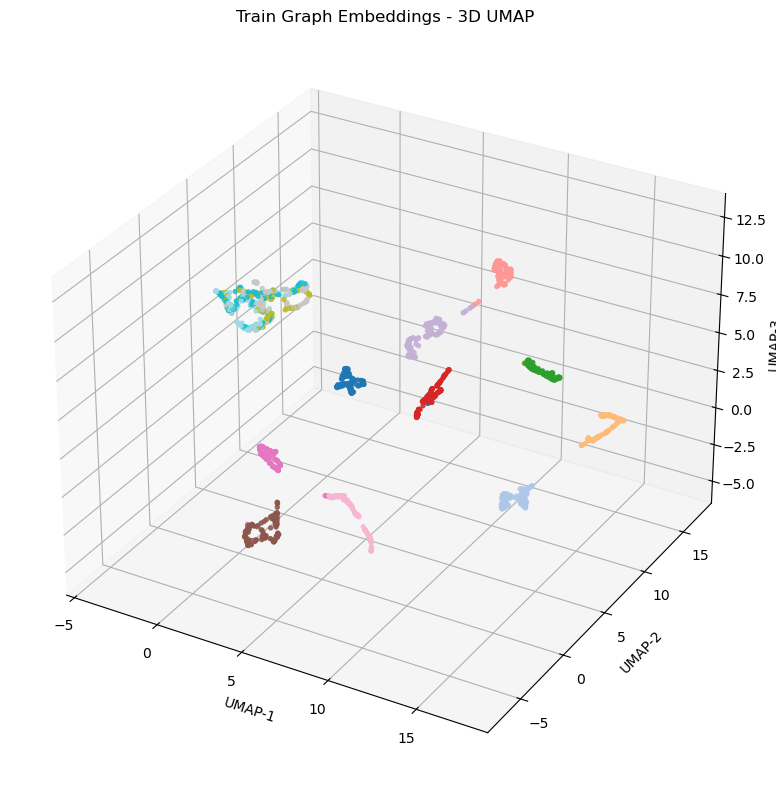

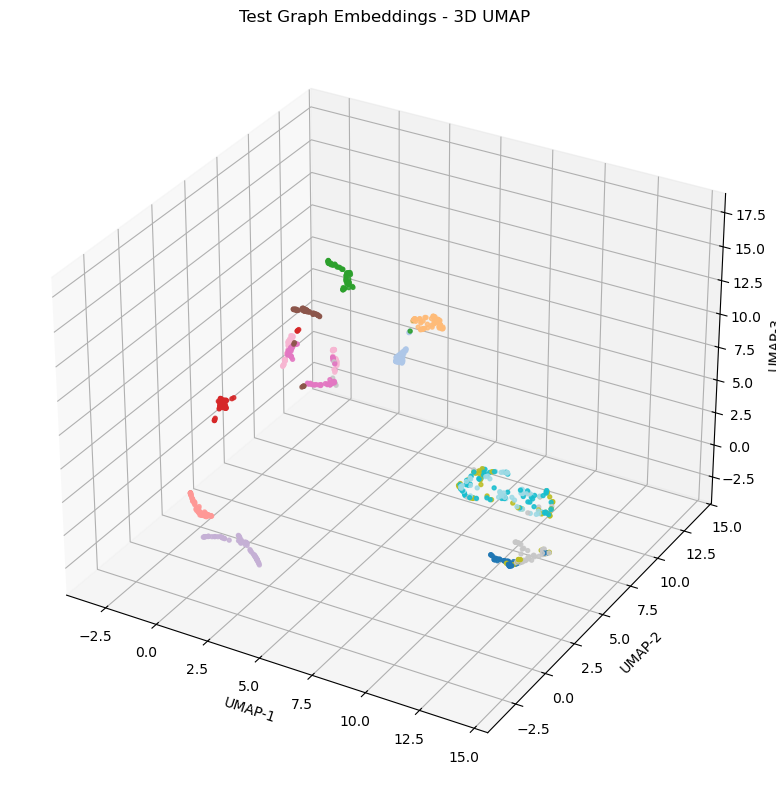


🎯 Train / Test 3D UMAP 全部完成并保存！


In [3]:
# ======================================================================
#                ⭐ 单 Cell：不会报错的模型加载 + Train/Test 3D 可视化 ⭐
# ======================================================================

# ====================== 环境导入 ======================
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
from mpl_toolkits.mplot3d import Axes3D

# ====================== 路径 ======================
save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_CWT/result/time_CWT"
os.makedirs(save_dir, exist_ok=True)

model_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_CWT/model_save/time_CWT/KAIST_normal_pretrain_best.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====================== 加载训练时的真实模型结构 ======================
from models import GraphContrastiveLearner   

# ----- 加载 checkpoint -----
checkpoint = torch.load(model_path, map_location=device)
cfg = checkpoint["config"]

# ----- 按训练时的方式实例化模型（不会报错 👍）-----
model = GraphContrastiveLearner(
    in_dim     = cfg["in_dim"],
    hidden_dim = cfg["hidden_dim"],
    out_dim    = cfg["out_dim"],
    proj_dim   = cfg["proj_dim"],
    tau        = cfg["tau"] if "tau" in cfg else 0.5
).to(device)

# ----- 加载权重（不会报错 👍）-----
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("✅ 使用训练时的原始模型读取成功！不会报错")

# ======================================================================
#                ⭐ 1️⃣ 提取 Train 和 Test 的嵌入
# ======================================================================

# 你前面已经：train_data / test_data = torch.load(...)
train_data = train_data.to(device)
test_data  = test_data.to(device)

with torch.no_grad():
    _, z_train = model(train_data.x, train_data.edge_index)
    _, z_test  = model(test_data.x,  test_data.edge_index)

train_emb = z_train.cpu().numpy()
test_emb  = z_test.cpu().numpy()

train_labels = train_data.y.cpu().numpy() if hasattr(train_data, "y") else np.zeros(train_emb.shape[0])
test_labels  = test_data.y.cpu().numpy() if hasattr(test_data,  "y") else np.zeros(test_emb.shape[0])

print(f"⭐ Train Embeddings Shape: {train_emb.shape}")
print(f"⭐ Test  Embeddings Shape: {test_emb.shape}")

# ======================================================================
#                ⭐ 2️⃣ 3D UMAP 降维
# ======================================================================
reducer_train = umap.UMAP(
    n_neighbors=10, min_dist=0.1, n_components=3,
    metric="cosine", random_state=42
)
train_umap = reducer_train.fit_transform(train_emb)

reducer_test = umap.UMAP(
    n_neighbors=10, min_dist=0.1, n_components=3,
    metric="cosine", random_state=42
)
test_umap = reducer_test.fit_transform(test_emb)

# ======================================================================
#                ⭐ 3️⃣ 绘制 Train 3D UMAP
# ======================================================================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    train_umap[:,0], train_umap[:,1], train_umap[:,2],
    c=train_labels, cmap='tab20', s=8, alpha=0.85
)

ax.set_title("Train Graph Embeddings - 3D UMAP")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2"); ax.set_zlabel("UMAP-3")

legend = plt.legend(
    *scatter.legend_elements(num=None),
    title="Labels", loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8
)
ax.add_artist(legend)

plt.tight_layout(rect=[0,0,0.85,1])
plt.savefig(os.path.join(save_dir, "train_umap_3d.png"), dpi=300)
plt.show()

# ======================================================================
#                ⭐ 4️⃣ 绘制 Test 3D UMAP
# ======================================================================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    test_umap[:,0], test_umap[:,1], test_umap[:,2],
    c=test_labels, cmap='tab20', s=8, alpha=0.85
)

ax.set_title("Test Graph Embeddings - 3D UMAP")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2"); ax.set_zlabel("UMAP-3")

legend = plt.legend(
    *scatter.legend_elements(num=None),
    title="Labels", loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8
)
ax.add_artist(legend)

plt.tight_layout(rect=[0,0,0.85,1])
plt.savefig(os.path.join(save_dir, "test_umap_3d.png"), dpi=300)
plt.show()

# ======================================================================
#                ⭐ 5️⃣ 保存嵌入
# ======================================================================
np.save(os.path.join(save_dir, "train_emb.npy"), train_emb)
np.save(os.path.join(save_dir, "train_umap_3d.npy"), train_umap)
np.save(os.path.join(save_dir, "test_emb.npy"),  test_emb)
np.save(os.path.join(save_dir, "test_umap_3d.npy"),  test_umap)

print("\n🎯 Train / Test 3D UMAP 全部完成并保存！")


## 下游训练 

In [4]:
# ======================================================================
#        ⭐ 单 Cell：使用 train_withlabel_mask 整图训练下游分类器（含 val 验证集） ⭐
# ======================================================================
%run ../_init_path.py
from models import GraphContrastiveLearner, DownstreamKANClassifier

import torch
import torch.nn.functional as F
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======================================================================
# 1. 提取 train、val 的 encoder 表征
# ======================================================================

train_data = train_data.to(device)
val_data   = val_data.to(device)

model = model.to(device)
model.eval()

print("🚀 提取 train/val 编码特征（Encoder forward）...")

with torch.no_grad():
    h_train, _ = model(train_data.x, train_data.edge_index)
    h_val,   _ = model(val_data.x,   val_data.edge_index)

h_train = h_train.detach()
h_val   = h_val.detach()

# ======================================================================
#          ⭐ 对上游生成的嵌入表达 h_train / h_test 做 L2 归一化
# ======================================================================

def l2_normalize(h, eps=1e-8):
    return h / (h.norm(dim=1, keepdim=True) + eps)

h_train = l2_normalize(h_train)
h_val  = l2_normalize(h_val)

print("✨ 已完成嵌入向量的 L2 归一化！")

# ---- train ----
y_train = train_data.y
mask_train = train_data.train_withlabel_mask
idx_train = mask_train.nonzero(as_tuple=False).view(-1)
h_train_labeled = h_train[idx_train]
y_train_labeled = y_train[idx_train]

# ---- val（全部 val 节点用于验证） ----
y_val = val_data.y

print(f"📌 Train 有标签样本数: {h_train_labeled.shape[0]}")
print(f"📌 表征维度(out_dim): {h_train_labeled.shape[1]}")


# ======================================================================
# 2. 定义分类器
# ======================================================================

num_features = h_train_labeled.size(1)
num_classes = int(max(y_train_labeled.max(), y_val.max()).item() + 1)

classifier = DownstreamKANClassifier(
    in_dim=num_features,
    num_classes=num_classes,
    hidden_dim=128,
    num_knots=8
).to(device)

optimizer = Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-4)


# ======================================================================
# 3. 整图训练 + 验证集评估（保存最佳模型）
# ======================================================================

epochs = 100
best_val_acc = 0.0
best_state = None

print("\n================== 🔥 开始下游分类训练（含 val 验证） ==================\n")

for epoch in range(1, epochs + 1):

    # ---- Train step ----
    classifier.train()
    optimizer.zero_grad()

    logits_train = classifier(h_train_labeled)
    loss = F.cross_entropy(logits_train, y_train_labeled)
    loss.backward()
    optimizer.step()

    # ---- Val step ----
    classifier.eval()
    with torch.no_grad():
        logits_val = classifier(h_val)
        pred_val = logits_val.argmax(dim=1)
        acc_val = (pred_val == y_val).float().mean().item()

    # ---- 打印 ----
    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d}/{epochs} | Train Loss = {loss.item():.4f} | Val Acc = {acc_val*100:.2f}%")

    # ---- 保存最佳模型 ----
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        best_state = {
            "state_dict": classifier.state_dict(),
            "in_dim": num_features,
            "num_classes": num_classes
        }

print("\n🏁 下游分类器训练完成！")
print(f"🌟 最佳验证集准确率：{best_val_acc*100:.2f}%")


# ======================================================================
# 4. 保存验证集最优模型
# ======================================================================

save_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_CWT/model_save/time_CWT/downstream/downstream_classifier_val_best.pt"

torch.save(best_state, save_path)

print(f"💾 最佳（Val Acc最高）分类器已保存：{save_path}")


✅ 已添加路径：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_CWT
✅ 已添加 my_lib：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_CWT/src
🚀 提取 train/val 编码特征（Encoder forward）...
✨ 已完成嵌入向量的 L2 归一化！
📌 Train 有标签样本数: 491
📌 表征维度(out_dim): 256

================== 🔥 开始下游分类训练（含 val 验证） ==================

Epoch 005/100 | Train Loss = 2.6260 | Val Acc = 7.35%
Epoch 010/100 | Train Loss = 2.5602 | Val Acc = 15.81%
Epoch 015/100 | Train Loss = 2.4463 | Val Acc = 15.07%
Epoch 020/100 | Train Loss = 2.2783 | Val Acc = 29.78%
Epoch 025/100 | Train Loss = 2.0902 | Val Acc = 42.28%
Epoch 030/100 | Train Loss = 1.8907 | Val Acc = 49.26%
Epoch 035/100 | Train Loss = 1.7067 | Val Acc = 51.10%
Epoch 040/100 | Train Loss = 1.5370 | Val Acc = 54.78%
Epoch 045/100 | Train Loss = 1.3887 | Val Acc = 63.60%
Epoch 050/100 | Train Loss = 1.2618 | Val Acc = 63.97%
Epoch 055/100 | Train Loss = 1.1531 | Val Acc = 6

## 最终acc测试

In [5]:
# ======================================================================
#    ⭐ 单 Cell：加载上游模型 + 下游分类器，并计算 Train/Test Accuracy ⭐
# ======================================================================

import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====================== 模型路径 ======================
pretrain_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_CWT/model_save/time_CWT/KAIST_normal_pretrain_best.pt"

classifier_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_CWT/model_save/time_CWT/downstream/downstream_classifier_val_best.pt"

print("📌 模型路径已设置")


# ====================== 加载模型结构 ======================
from models import GraphContrastiveLearner, DownstreamKANClassifier

# ------- 加载上游 GCL 模型 -------
ckpt = torch.load(pretrain_path, map_location=device)
cfg = ckpt["config"]

model = GraphContrastiveLearner(
    in_dim     = cfg["in_dim"],
    hidden_dim = cfg["hidden_dim"],
    out_dim    = cfg["out_dim"],
    proj_dim   = cfg["proj_dim"],
    tau        = cfg["tau"] if "tau" in cfg else 0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])   # ⭐ 不会报错的加载方式
model.eval()
print("✅ 上游模型加载成功！")


# ------- 加载下游分类器 -------
clf_ckpt = torch.load(classifier_path, map_location=device)
in_dim = clf_ckpt["in_dim"]
num_classes = clf_ckpt["num_classes"]

classifier = DownstreamKANClassifier(
    in_dim=in_dim,
    num_classes=num_classes,
    hidden_dim=128,
    num_knots=8
).to(device)

classifier.load_state_dict(clf_ckpt["state_dict"])
classifier.eval()
print("✅ 下游分类器加载成功！")


# ====================== 加载 Train / Test 图 ======================
# 你在 notebook 中应该已经手动加载好了：
# train_data = torch.load(...)
# test_data = torch.load(...)

train_data = train_data.to(device)
test_data = test_data.to(device)

print("📌 Train/Test 图数据已加载至 GPU/CPU")


# ======================================================================
#          ⭐ 1️⃣ 提取 Train/Test 的 GCL encoder 表征 h
# ======================================================================
with torch.no_grad():
    h_train, _ = model(train_data.x, train_data.edge_index)
    h_test,  _ = model(test_data.x,  test_data.edge_index)

print("🔧 已提取上游编码特征 h_train / h_test")
h_train  = l2_normalize(h_train)
h_test  = l2_normalize(h_test)

# ======================================================================
#          ⭐ 2️⃣ Train Accuracy（仅 train_withlabel_mask）
# ======================================================================
train_mask = train_data.train_withlabel_mask
train_idx = train_mask.nonzero(as_tuple=False).view(-1)

h_labeled = h_train[train_idx]
y_labeled = train_data.y[train_idx]

with torch.no_grad():
    logits_train = classifier(h_labeled)
    pred_train = logits_train.argmax(dim=1)

acc_train = (pred_train == y_labeled).float().mean().item()

print(f"\n🎯 Train Accuracy (train_withlabel_mask) = {acc_train*100:.2f}%")

# ======================================================================
#          ⭐ 3️⃣ Test Accuracy（全部 test 节点）
# ======================================================================
with torch.no_grad():
    logits_test = classifier(h_test)
    pred_test = logits_test.argmax(dim=1)

acc_test = (pred_test == test_data.y).float().mean().item()

print(f"🎯 Test Accuracy  (all test nodes) = {acc_test*100:.2f}%")

print("\n🏁 全部 accuracy 评估完成！")


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# ====================== ⭐ Train metrics ======================
y_true_train = y_labeled.cpu().numpy()
y_pred_train = pred_train.cpu().numpy()

train_acc  = accuracy_score(y_true_train, y_pred_train)
train_prec = precision_score(y_true_train, y_pred_train, average="macro", zero_division=0)
train_reca = recall_score(y_true_train, y_pred_train, average="macro", zero_division=0)
train_f1   = f1_score(y_true_train, y_pred_train, average="macro", zero_division=0)

print("\n====================== TRAIN METRICS ======================")
print(f"Accuracy : {train_acc*100:.2f}%")
print(f"Precision: {train_prec*100:.2f}%")
print(f"Recall   : {train_reca*100:.2f}%")
print(f"F1-score : {train_f1*100:.2f}%")
print("===========================================================\n")


# ====================== ⭐ Test metrics ======================
y_true_test = test_data.y.cpu().numpy()
y_pred_test = pred_test.cpu().numpy()

test_acc  = accuracy_score(y_true_test, y_pred_test)
test_prec = precision_score(y_true_test, y_pred_test, average="macro", zero_division=0)
test_reca = recall_score(y_true_test, y_pred_test, average="macro", zero_division=0)
test_f1   = f1_score(y_true_test, y_pred_test, average="macro", zero_division=0)

print("======================= TEST METRICS =======================")
print(f"Accuracy : {test_acc*100:.2f}%")
print(f"Precision: {test_prec*100:.2f}%")
print(f"Recall   : {test_reca*100:.2f}%")
print(f"F1-score : {test_f1*100:.2f}%")
print("===========================================================\n")
# ======================================================================
#          ⭐ 4️⃣ 统计预测错误的样本（真实标签 vs 预测标签）
# ======================================================================

import numpy as np
from collections import Counter

# ========== Train 错误样本 ==========
wrong_train_idx = np.where(y_pred_train != y_true_train)[0]

print("============== TRAIN WRONG PREDICTIONS ==============")
print(f"❌ 错误样本数量：{len(wrong_train_idx)} / {len(y_true_train)}")

# 打印前 20 个错误样本（避免太长）
max_show = 20
for i in wrong_train_idx[:max_show]:
    print(f"Index {i:4d} | True = {y_true_train[i]} | Pred = {y_pred_train[i]}")
if len(wrong_train_idx) > max_show:
    print(f"... (共 {len(wrong_train_idx)} 个错样本，只显示前 {max_show} 个)")

# 每类错误统计
train_wrong_pairs = [(int(y_true_train[i]), int(y_pred_train[i])) for i in wrong_train_idx]
train_wrong_count = Counter(train_wrong_pairs)

print("\n🔍 Train 每类错误统计：(真标签 -> 预测标签)")
for (t, p), cnt in train_wrong_count.items():
    print(f"  {t} → {p} : {cnt} 次")


# ========== Test 错误样本 ==========
wrong_test_idx = np.where(y_pred_test != y_true_test)[0]

print("\n============== TEST WRONG PREDICTIONS ===============")
print(f"❌ 错误样本数量：{len(wrong_test_idx)} / {len(y_true_test)}")

for i in wrong_test_idx[:max_show]:
    print(f"Index {i:4d} | True = {y_true_test[i]} | Pred = {y_pred_test[i]}")
if len(wrong_test_idx) > max_show:
    print(f"... (共 {len(wrong_test_idx)} 个错样本，只显示前 {max_show} 个)")

# 每类错误统计
test_wrong_pairs = [(int(y_true_test[i]), int(y_pred_test[i])) for i in wrong_test_idx]
test_wrong_count = Counter(test_wrong_pairs)

print("\n🔍 Test 每类错误统计：(真标签 -> 预测标签)")
for (t, p), cnt in test_wrong_count.items():
    print(f"  {t} → {p} : {cnt} 次")

print("\n🏁 错误样本统计完成！")


📌 模型路径已设置
✅ 上游模型加载成功！
✅ 下游分类器加载成功！
📌 Train/Test 图数据已加载至 GPU/CPU
🔧 已提取上游编码特征 h_train / h_test

🎯 Train Accuracy (train_withlabel_mask) = 82.69%
🎯 Test Accuracy  (all test nodes) = 78.14%

🏁 全部 accuracy 评估完成！

====================== TRAIN METRICS ======================
Accuracy : 82.69%
Precision: 80.32%
Recall   : 83.52%
F1-score : 81.41%

======================= TEST METRICS =======================
Accuracy : 78.14%
Precision: 74.91%
Recall   : 78.24%
F1-score : 75.73%

============== TRAIN WRONG PREDICTIONS ==============
❌ 错误样本数量：85 / 491
Index  112 | True = 3 | Pred = 4
Index  144 | True = 5 | Pred = 2
Index  172 | True = 5 | Pred = 6
Index  209 | True = 7 | Pred = 3
Index  210 | True = 7 | Pred = 3
Index  337 | True = 11 | Pred = 14
Index  338 | True = 11 | Pred = 12
Index  342 | True = 11 | Pred = 1
Index  343 | True = 11 | Pred = 1
Index  344 | True = 11 | Pred = 1
Index  345 | True = 11 | Pred = 1
Index  348 | True = 11 | Pred = 12
Index  349 | True = 11 | Pred = 12
Index  350 |

/tmp/ipykernel_13277/3897915642.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(pretrain_path, map_location=device)
/tmp/ipykernel_13277/3897915642.py